## Astronomy 406 "Computational Astrophysics" (Fall 2016)

### Week 7: Confidence limits, Drawing from a distribution, Parametric bootstrap

<b>Reading:</b> notes below, as well as $\S$[15.6](https://umich.instructure.com/files/2682016/download?download_frd=1) and [7.3](https://umich.instructure.com/files/2832366/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes), and $\S$3.7, 4.2-4.3, 4.5, 8.2, and 8.8 of [Machine Learning](http://www.astroml.org/)</a>.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 80
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, interpolate, stats, special
np.random.seed(0)

In Week 6 notebook we have derived the maximum likelihood for linear regression with instrinsic scatter:

$y = f(x | a,b,\sigma) = a + b x + \epsilon$,

where the scatter of each data point $\epsilon_i$ is described by a normal distribution $N(0,\sigma)$.  Omitting a normalization constant, the log-likelihood is

$2\ln{\cal L} = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 / \sigma_i^2}$,

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.

The intercept value $a$ can be calculated analytically as 
$a = {\sum_i w_i (y_i - b x_i) / \sum_i w_i}$, with $w_i \equiv \sigma_{i}^{-2}$.

Using the weights $w_i$, the function to be minimized can be written concisely as

$-2\ln{\cal L} = -\sum_i \ln{w_i} + \sum_i w_i (y_i - a - b x_i)^2$.

### Bootstrap

What do estimated errors of the best-fit parameters mean?  Do they obey a Gaussian statistic with mean $a$ and standard deviation $da$?  Or do they obey a different distribution, and how can we know that?  These questions are the reason to try to understand the whole distribution of the model parameters.

One of the simplest, and yet accurate and effective, ways of estimating the parameter distribution is <b>bootstrap</b>.  In this method we create many new datasets based on the original dataset, and derive the best-fit parameters for all of them, thus creating a distribution of the parameter values.  The trick is to have the new datasets to obey the same distribution function as the original sample.  This is achieved by drawing data points from the original dataset $x_i, y_i$, with repetition.

The simplest way to draw a bootstrap sample is to generate a new array of indices $j$, composed of random integers from 0 to $N-1$. Then the new data set is simply $x_j, y_j$.  The phrase "with repetition" means that some data points may appear in the new dataset multiple times, while some others will disappear.

<b>Exercise:</b> Re-write the $2\ln{\cal L}$ function to take additional arguments for the bootstrapped sample ($x,y,dx,dy$).  Write additional function that evaluates the intercept given the parameter array $p$ and the bootstrapped sample.

In [2]:
def intercept(p, xb, yb, dxb, dyb):
    b, s = p
    sig2_i = dyb**2 + (b * dxb)**2 + s**2
    w_i = 1. / sig2_i
    a = np.sum(w_i * (yb - b * xb)) / np.sum(w_i)
    return a

def lnLikelihood(p, xb, yb, dxb, dyb):
    b, s = p
    sig2_i = dyb**2 + (b * dxb)**2 + s**2
    w_i = 1. / sig2_i
    a = np.sum(w_i * (yb - b * xb)) / np.sum(w_i)
    lnSum = np.sum(np.log(sig2_i))
    chiSum = np.sum((yb - a - b*xb)**2 * w_i)
    return (lnSum + chiSum)



iboot = 100 d = 8.8817
a = -6.669 ± 0.359 b = 1.431 ± 0.036 s = 0.365 ± 0.023
iboot = 200 d = 0.0380
a = -6.687 ± 0.345 b = 1.433 ± 0.034 s = 0.365 ± 0.022
iboot = 300 d = 0.0283
a = -6.707 ± 0.349 b = 1.435 ± 0.034 s = 0.364 ± 0.022


/Users/Jacob/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:895: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


iboot = 400 d = 0.0140
a = -6.715 ± 0.345 b = 1.436 ± 0.034 s = 0.364 ± 0.023
iboot = 500 d = 0.0079
a = -6.712 ± 0.342 b = 1.435 ± 0.033 s = 0.365 ± 0.022
iboot = 600 d = 0.0159
a = -6.722 ± 0.346 b = 1.436 ± 0.034 s = 0.365 ± 0.022
iboot = 700 d = 0.0120
a = -6.715 ± 0.343 b = 1.436 ± 0.034 s = 0.366 ± 0.022
iboot = 800 d = 0.0061
a = -6.716 ± 0.347 b = 1.436 ± 0.034 s = 0.365 ± 0.022
iboot = 900 d = 0.0056
a = -6.714 ± 0.350 b = 1.436 ± 0.034 s = 0.365 ± 0.022


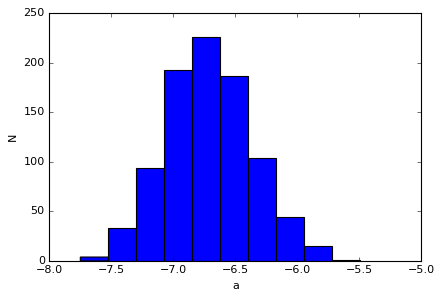

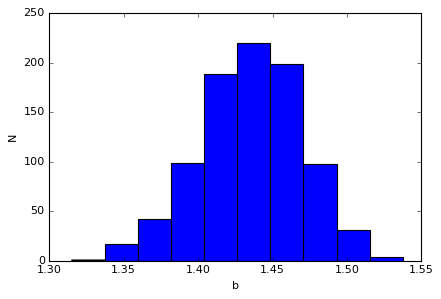

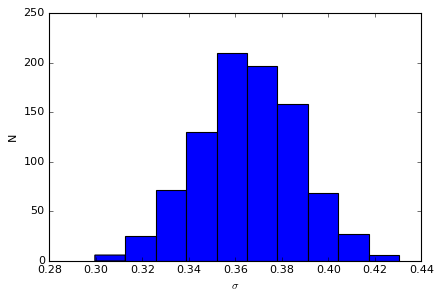

In [3]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt('gc_galaxy.dat', unpack=True)
ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

nd = len(x)
aa, bb, ss = [], [], []
amean, bmean, smean = 0., 0., 0.
asig, bsig, ssig = 0., 0., 0.
iboot = 0
icheck = 100
inext = icheck
cont = True

while cont and iboot < 10000:
    
    iboot += 1
    ir = np.random.randint(0, nd, nd)
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir];
    
    o = optimize.minimize(lnLikelihood, [1.,0.1], args=(xb, yb, dxb, dyb))
    
    aa.append(intercept(o.x, xb, yb, dxb, dyb))
    bb.append(o.x[0])
    ss.append(abs(o.x[1]))
    
    if iboot >= inext:
        amean_last, bmean_last, smean_last = amean, bmean, smean
        asig_last, bsig_last, ssig_last = asig, bsig, ssig
        amean, bmean, smean = np.mean(aa), np.mean(bb), np.mean(ss)
        asig, bsig, ssig = np.std(aa), np.std(bb), np.std(ss)
        
        d = abs(amean-amean_last) + abs(bmean-bmean_last) + abs(smean-smean_last)\
            + abs(asig-asig_last) + abs(bsig-bsig_last) + abs(ssig-ssig_last)
            
        if d < 0.006:
            cont = False
            
        print "iboot =", iboot, "d = {0:.4f}".format(d)
        print "a = {0:.3f} ± {1:.3f} b = {2:.3f} ± {3:.3f} s = {4:.3f} ± {5:.3f}"\
              .format(amean, asig, bmean, bsig, smean, ssig)
        inext += icheck    

plt.xlabel('a')
plt.ylabel('N')
plt.hist(aa)
plt.show()

plt.xlabel('b')
plt.ylabel('N')
plt.hist(bb)
plt.show()

plt.xlabel('$\sigma$')
plt.ylabel('N')
plt.hist(ss)
plt.show()

In [4]:
f = open('bootstrap.dat', 'w')
for i in range(len(aa)):
    f.write('%.4f %.4f %.4f\n' % (aa[i], bb[i], ss[i]))
f.close()

Let's now plot the range of models allowed by the best-fit parameters and their errors.

In [5]:
plt.plot(xa, a+b*xa, 'r-')
plt.plot(xa, a+(b+bsig)*xa, 'r-')
plt.plot(xa, a+(b-bsig)*xa, 'r-')
plt.plot(xa, a+asig+b*xa, 'b-')
plt.plot(xa, a-asig+b*xa, 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

NameError: name 'xa' is not defined

### Confidence limits

Bootstrap gives us the distributions of each of the model parameters.  We can use them to set confidence limits on the derived best-fit parameters.

<b>Exercise:</b> Write a routine to calculate the range containing a given percentage of the bootstrap distribution, for each of the model parameters.  For example, return $da$ such that 90% (should be free parameter) of the values of $a$ are within $a \pm da$.

Having bootstrap distributions also allows us to investigate the relations between the best-fit parameters.  For example, there is a strong anti-correlation of $a$ and $b$:

In [6]:
# new modules that will be needed here
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

# read saved bootstrap realization
aa, bb, ss = np.loadtxt("bootstrap.dat", unpack=True)

# read original data
Lgal, dLgal, Mgc, dMgc = np.loadtxt("gc_galaxy.dat", unpack=True)
ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

Boot: a = -6.7139 ± 0.3498  b = 1.4357 ± 0.0343  sig = 0.3654 ± 0.0216


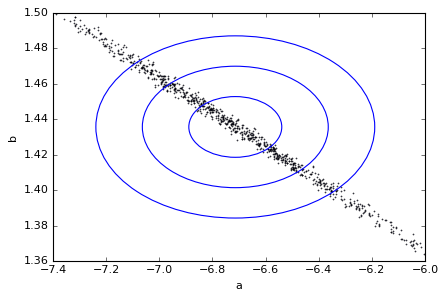

In [7]:
plt.xlim(-7.4, -6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=0.2)

mean = [np.mean(aa), np.mean(bb)]
sigma1 = np.std(aa)
sigma2 = np.std(bb)

print 'Boot: a = %.4f ± %.4f  b = %.4f ± %.4f  sig = %.4f ± %.4f' %\
  (np.mean(aa), np.std(aa), np.mean(bb), np.std(bb), np.mean(ss), np.std(ss))
    
for Nsig in (1, 2, 3):    
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=0, ec='b', fc='none'))

The blue contours enclose the expected $1\sigma$, $2\sigma$, and $3\sigma$ distribution of the parameters, in the absence of their correlation.  Clearly, they do not correspond to the actual distribution.

An alternative method, suggested by <a href="http://arxiv.org/abs/1008.4686">Hogg et al.</a>, effectivel rotates the coordinate system to align with the correlation and fits the ellipses along and perpendicular to it.  The resulting contours are much tighter!

Corr: sigma 1 = 0.3515  sigma 2 = 0.0023  angle = -0.0975
Corr: a = -6.7139 ± 0.3496  b = 1.4357 ± 0.0365


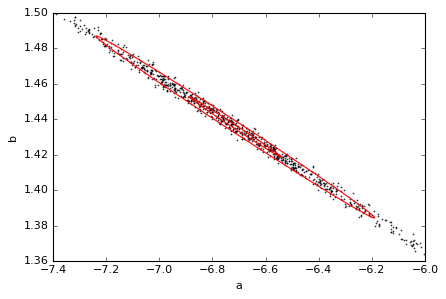

In [8]:
plt.xlim(-7.4, -6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=0.2)

mean, sigma1, sigma2, alpha = fit_bivariate_normal(aa, bb, robust=False) #From AstroML

da = sigma1*np.cos(alpha) + sigma2*np.sin(alpha)
db = -sigma1*np.sin(alpha) + sigma2*np.cos(alpha)

print 'Corr: sigma 1 = %.4f  sigma 2 = %.4f  angle = %.4f' % (sigma1, sigma2, alpha)
print 'Corr: a = %.4f ± %.4f  b = %.4f ± %.4f' % (mean[0], da, mean[1], db)

for Nsig in (1, 3):
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=alpha*180./np.pi, ec='r', fc='none'))

Hogg's method does not depend on whether we fit $x$ vs. $y$, or $y$ vs. $x$.  We will see below that it is a very useful property.  However, it has a potential pitfall in the interpretation of dispersions $\sigma_1$ and $\sigma_2$ when the variables $a$ and $b$ have different units.

There is another solution.  The correlation of $a$ and $b$ arises because the pivot point of our linear model (at $x=0$) is far from the actual range of data ($x>0$).  We can reduce it by choosing a different pivot point, somewhere in the middle of the distribution.  For example, the mean value of $x$.  This means we are re-defining our model as

$y = f(x | a,b,\sigma) = a + b (x-x_0) + \epsilon$.

The new intercept relates to the old one as $a_{new} = a_{old} + b x_0$. We should remember it when comparing results with the previous fit.

Why should this work? a and b are directly related - as we change the slope b, we will have to change the intercept a to continue to fit the data. Thus why our trick of subtracting $x_0$ works - we change our 'zero' to be in the middle of our data set.

We will use the simplest case where $x_0$ is just a constant.

In [9]:
def lnLikelihood0( p, xb, yb, dxb, dyb, x0 ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*(xb-x0)))/np.sum(w)
    return np.sum(-np.log(w) + w*(yb-a-b*(xb-x0))**2)

def intercept0( p, xb, yb, dxb, dyb, x0 ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*(xb-x0)))/np.sum(w)
    return a

In [10]:
x0 = np.mean(x)

aa0, bb0, ss0 = [], [], []

for iboot in range(1100):
    ir = np.random.randint(low=0, high=len(x), size=len(x))
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir];
    
    o = optimize.minimize(lnLikelihood0, [1.,0.1], args=(xb,yb,dxb,dyb,x0))
    
    bb0.append(o.x[0])
    ss0.append(abs(o.x[1]))
    aa0.append(intercept0(o.x,xb,yb,dxb,dyb,x0))

Boot: a = 7.9957 +- 0.0238  b = 1.4350 +- 0.0341  sig = 0.3641 +- 0.0213
x0 = 10.247  a = 7.9957 +- 0.0261  b = 1.4350 +- 0.0356


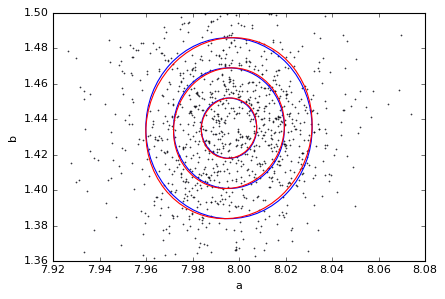

In [11]:
plt.xlim(7.92, 8.08)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa0, bb0, s=0.2)

# plot bootstrap distribution
mean = [np.mean(aa0), np.mean(bb0)]
sigma1 = np.std(aa0)
sigma2 = np.std(bb0)

print 'Boot: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f' %\
  (np.mean(aa0), np.std(aa0), np.mean(bb0), np.std(bb0), np.mean(ss0), np.std(ss0))
    
for Nsig in (1, 2, 3):    
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=0, ec='b', fc='none'))

# Hogg's method
mean, sigma1, sigma2, alpha = fit_bivariate_normal(aa0, bb0, robust=False) #from astroML

da = abs(sigma1*np.cos(alpha) + sigma2*np.sin(alpha))
db = abs(sigma1*np.sin(alpha) + sigma2*np.cos(alpha))

print 'x0 = %.3f  a = %.4f +- %.4f  b = %.4f +- %.4f' % (x0, mean[0], da, mean[1], db)

for Nsig in (1, 2, 3):
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=alpha*180./np.pi, ec='r', fc='none'))

There is still some residual correlation of $a$ and $b$.  It can be minimized by a more sophisticated choice of the offset $x_0$.

Now let's plot the new fit and check that it still fits the original data. 

Note that a is radically different - we need to apply $a_{new} = a_{old} + bx_0$.

x0 = 10.247  a = 7.9975 +- 0.0238  b = 1.4353 +- 0.0341  sig = 0.3669 +- 0.0213


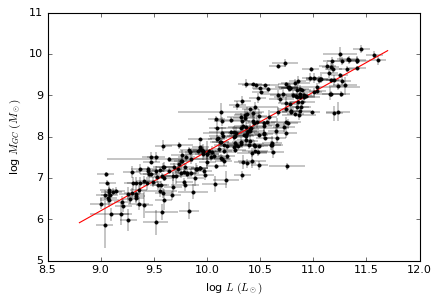

In [12]:
o = optimize.minimize(lnLikelihood0, [1.,0.1], args=(x,y,dx,dy,x0))

a = intercept0(o.x,x,y,dx,dy,x0)
b = o.x[0]
sig = abs(o.x[1])
da = np.std(aa0)
db = np.std(bb0)
dsig = np.std(ss0)

print 'x0 = %.3f  a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f' %\
  (x0, a, da, b, db, sig, dsig)

xa = np.array([8.8, 11.7])
plt.plot(xa, a+b*(xa-x0), 'r-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

Let's plot the best model with the parameter errors:

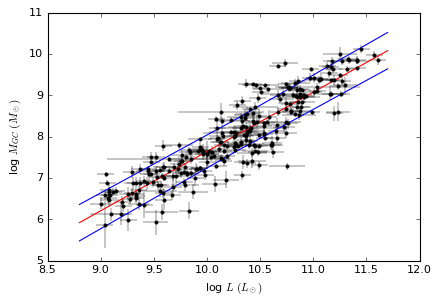

In [13]:
xa1 = np.array([8.8, x0])
plt.plot(xa1, a+b*(xa1-x0), 'r-')
plt.plot(xa1, a+(da+sig)+(b-db)*(xa1-x0), 'b-')
plt.plot(xa1, a-(da+sig)+(b+db)*(xa1-x0), 'b-')

xa2 = np.array([x0, 11.7])
plt.plot(xa2, a+b*(xa2-x0), 'r-')
plt.plot(xa2, a+(da+sig)+(b+db)*(xa2-x0), 'b-')
plt.plot(xa2, a-(da+sig)+(b-db)*(xa2-x0), 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

### Forward fitting vs. Backward fitting

So far we have treated $x$ as an independent variable and $y$ as dependent variable, because we minimized the differences of $y_i$ from the model.  What if both variables are measured independently and we want to find the relation between them?  Do we get the same model if we fit $x$ vs. $y$?  For simplicity let's do it without the offsets.

$x = c + d \, y + \epsilon$

What are the expected values of $c$ and $d$ from our original fit parameters, $a$ and $b$?

<b>Exercise 1:</b> Evaluate the backward fit and compare with the expected parameter values.  Plot the new model with the data.

In [43]:
def intercept(p, xb, yb, dxb, dyb):
    d, s = p
    sig2_i = dxb**2 + (d * dyb)**2 + s**2
    w_i = 1. / sig2_i
    c = np.sum(w_i * (xb - d * yb)) / np.sum(w_i)
    return c

def lnLikelihood(p, xb, yb, dxb, dyb):
    d, s = p
    sig2_i = dxb**2 + (d * dyb)**2 + s**2
    w_i = 1. / sig2_i
    c = np.sum(w_i * (xb - d * yb)) / np.sum(w_i)
    lnSum = np.sum(np.log(sig2_i))
    chiSum = np.sum((xb - c - d*yb)**2 * w_i)
    return (lnSum + chiSum)

iboot = 100 d = 6.6254
c = 5.662 ± 0.130 d = 0.574 ± 0.016 s = 0.231 ± 0.011
iboot = 200 d = 0.0288
c = 5.651 ± 0.144 d = 0.575 ± 0.018 s = 0.231 ± 0.012
iboot = 300 d = 0.0142
c = 5.655 ± 0.136 d = 0.574 ± 0.017 s = 0.231 ± 0.012
iboot = 400 d = 0.0078
c = 5.661 ± 0.137 d = 0.574 ± 0.017 s = 0.231 ± 0.012
iboot = 500 d = 0.0032
c = 5.659 ± 0.136 d = 0.574 ± 0.017 s = 0.231 ± 0.013
For comparison: 1/b = 0.696720129491  and -a/b = -5.57200561652


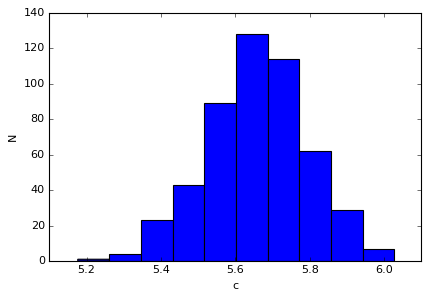

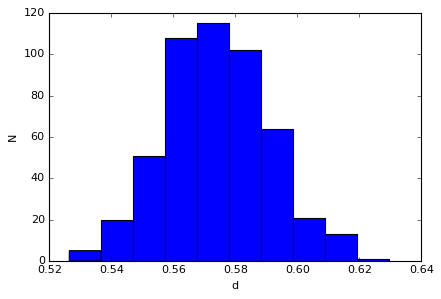

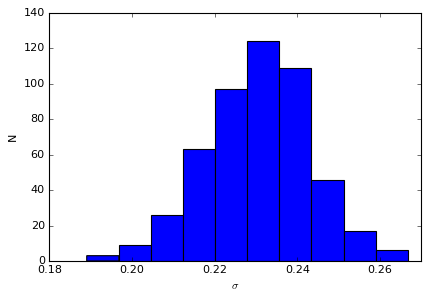

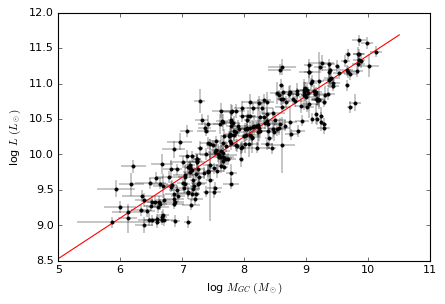

In [45]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt('gc_galaxy.dat', unpack=True)
ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

nd = len(x)
cc, dd, ss = [], [], []
cmean, dmean, smean = 0., 0., 0.
csig, dsig, ssig = 0., 0., 0.
iboot = 0
icheck = 100
inext = icheck
cont = True

while cont and iboot < 10000:
    
    iboot += 1
    ir = np.random.randint(0, nd, nd)
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir];
    
    o = optimize.minimize(lnLikelihood, [1.,0.1], args=(xb, yb, dxb, dyb))
    
    cc.append(intercept(o.x, xb, yb, dxb, dyb))
    dd.append(o.x[0])
    ss.append(abs(o.x[1]))
    
    if iboot >= inext:
        cmean_last, dmean_last, smean_last = cmean, dmean, smean
        csig_last, dsig_last, ssig_last = csig, dsig, ssig
        cmean, dmean, smean = np.mean(cc), np.mean(dd), np.mean(ss)
        csig, dsig, ssig = np.std(cc), np.std(dd), np.std(ss)
        
        d = abs(cmean-cmean_last) + abs(dmean-dmean_last) + abs(smean-smean_last)\
            + abs(csig-csig_last) + abs(dsig-dsig_last) + abs(ssig-ssig_last)
            
        if d < 0.006:
            cont = False
            
        print "iboot =", iboot, "d = {0:.4f}".format(d)
        print "c = {0:.3f} ± {1:.3f} d = {2:.3f} ± {3:.3f} s = {4:.3f} ± {5:.3f}"\
              .format(cmean, csig, dmean, dsig, smean, ssig)
        inext += icheck    

print 'For comparison: 1/b =', 1. / b, ' and -a/b =', a / b

plt.xlabel('c')
plt.ylabel('N')
plt.hist(cc)
plt.show()

plt.xlabel('d')
plt.ylabel('N')
plt.hist(dd)
plt.show()

plt.xlabel('$\sigma$')
plt.ylabel('N')
plt.hist(ss)
plt.show()

ya = np.array([5.0, 10.5])
plt.plot(ya, cmean + dmean*ya, 'r-')

plt.errorbar(y, x, xerr=dy, yerr=dx, fmt='.k', elinewidth=0.4, capsize=0)
plt.ylabel(r'log $L \ (L_\odot)$')
plt.xlabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

This disparity between the expected and calculated values of c and d arises because of the error bars - we get an uncertainty. (This is eliminated in the Hogg's method, because of how it creates a 'pivot point' for the data.)
We can also check that our backwards-calculated line by plotting it and checking if it is within the error bars on the plot above, right before this section.

<b>Exercise 2:</b> Write a function that calculates bootstrapped estimate of $da$, with $x_0$ as an input argument. Find $x_0$ that minimizes $da$. Check the residual correlation of $a$ and $b$, and plot results.

### Drawing from a distribution

It is often useful to be able to generate a simulated random sample drawn from a specified distribution.  This distribution may be analytical or discrete, such as an existing data sample.  A simulated sample can be used for comparison with data, in a technique called <i>parametric bootstrap</i>.

A general and very simple way to generate a simulated sample is the <b>transformation method</b>, described in $\S$7.3.2 of <a href="http://www.nr.com">Numerical Recipes</a> or $\S$3.7 of <a href="http://www.astroml.org/">Machine Learning</a>.  

<a href="http://www.astroml.org/book_figures/chapter3/fig_clone_distribution.html">Figure 3.25</a> provides a good illustration.

The example below shows how to clone a discrete sample.

KS test: D = 0.027; p = 1


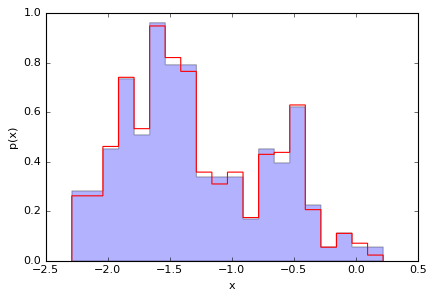

In [18]:
feh = np.loadtxt("gc.dat", usecols=(0,), unpack=True)

x = np.copy(feh)
x.sort()
Px = np.linspace(0, 1, len(x))

pspline = interpolate.UnivariateSpline(Px, x, s=0)

Nsample = 1000
Px_sample = np.linspace(0, 1, Nsample)
x_sample = pspline(Px_sample)

D, p = stats.ks_2samp(x, x_sample)
print "KS test: D = %.2g; p = %.2g" % (D, p)

plt.hist(x, bins=20, normed=True, histtype='stepfilled', alpha=0.3)
plt.hist(x_sample, bins=20, normed=True, histtype='step', color='r')
plt.xlabel('x')
plt.ylabel('p(x)')

Now let's generate a normal distribution from the analytical DF, and compare it with the SciPy's implementation.

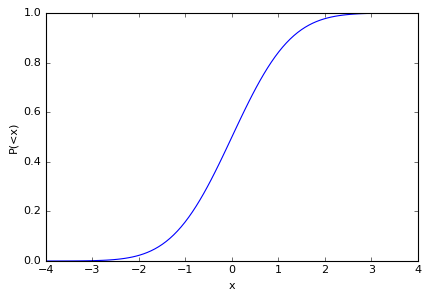

In [20]:
Nsample = 1000
mu = 0.
sig = 1.
x_norm = np.random.normal(mu, sig, Nsample)

x = np.linspace(mu-4*sig, mu+4*sig, 100)
Px = (1.+special.erf((x-mu)/sig/np.sqrt(2.)))/2.

plt.plot(x, Px)
plt.xlabel('x')
plt.ylabel('P(<x)')
plt.show()

KS test: D = 0.033; p = 0.64


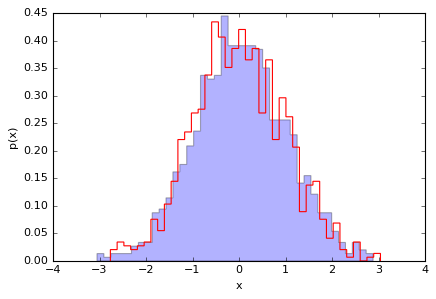

In [23]:
pspline = interpolate.UnivariateSpline(Px, x, s=0)

#Px_sample = np.linspace(0, 1, Nsample) #Not random
Px_sample = np.random.uniform(0, 1, Nsample) #Random
x_sample = pspline(Px_sample)

D, p = stats.ks_2samp(x_norm, x_sample)
print "KS test: D = %.2g; p = %.2g" % (D, p)

plt.hist(x_norm, bins=40, normed=True, histtype='stepfilled', alpha=0.3)
plt.hist(x_sample, bins=40, normed=True, histtype='step', color='r')
plt.xlabel('x')
plt.ylabel('p(x)')

### Parametric bootstrap

The idea of parametric bootstrap is to test whether an observed data set is consistent with a specified distribution.  For example, is our sample of globular cluster metallicities consistent with a normal distribution?
Essential idea - we're generating a bunch of samples with a given distribution that we want to compare our data to. (Testing the null hypothesis that our data does not follow he distribution we want to test.)

To answer this question, we need to:
1. Find a best-fitting normal distribution (calculate mean and standard deviation)
2. Calculate a merit function (goodness of fit, for example, $\chi^2$)
3. Generate simulated samples corresponding to the best-fit model
4. Estimate probability of the observed statistic in point 2 occuring in the parametric bootstrap samples. 

<b>Exercise 3:</b> Write a parametric bootstrap test for the observed [Fe/H].

-1.29638297872 0.567804388595 1.0071942446


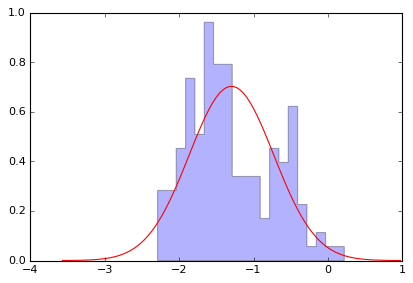

In [25]:
mu = np.mean(feh)
sig = np.std(feh, ddof=1)
chi2dof = np.sum(((feh-mu)/sig)**2)/(len(feh)-2) #Divided by degrees of freedom for normalization and answers that make sense - we will want chi-squared to be close to one
print mu, sig, chi2dof

plt.hist(feh, bins=20, normed=True, histtype='stepfilled', alpha=0.3)

x = np.linspace(mu-4*sig, mu+4*sig, 100)
plt.plot(x, 1./(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mu)/sig)**2/2), color='r')
plt.show()

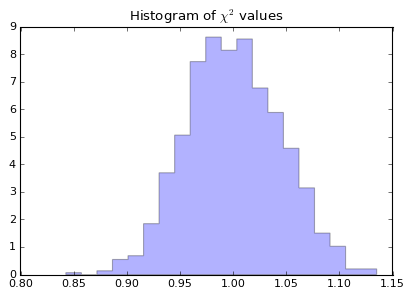

In [44]:
x = np.linspace(mu-4*sig, mu+4*sig, 100)
Px = (1.+special.erf((x-mu)/sig/np.sqrt(2.)))/2.
pspline = interpolate.UnivariateSpline(Px, x, s=0)

NSample = len(feh)
iboot = 0
chi2 = np.zeros(1000)
while iboot < 1000:
    Px_sample = np.random.uniform(0, 1, Nsample) #Mistake here - NSample must be the same as our data set.
    x_sample = pspline(Px_sample)
    chi2[iboot] = np.sum(((x_sample-mu)/sig)**2)/(len(x_sample)-2)
    iboot += 1

plt.hist(chi2, bins=20, normed=True, histtype='stepfilled', alpha=0.3)
plt.title('Histogram of $\chi^2$ values')
plt.show()


In [45]:

#To get the probability - we want the fraction of chis 
#that are outside the range (bootstrapped_chimean - chimeanofdata)

z = np.sort(np.fabs(np.mean(chi2) - chi2))
zobs = np.fabs(chi2dof - np.mean(chi2))
print 'probability that we are drawing samples from a normal distribution:', \
    len(z[z>zobs]) / np.float64(len(z))
#This means that our data is completely consistent with a normal distribution

probability that we are drawing samples from a normal distribution: 0.867
